# Build CNN

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


In [2]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True, #for training
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4, #process only 4 images at a time
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False, #not for training
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4, #process only 4 images at a time
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


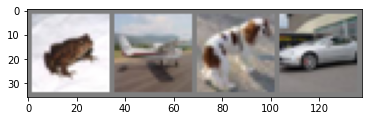

 frog plane   dog   car


In [3]:
import matplotlib.pyplot as plt
import numpy as np 

def imshow(img):
    img = img/2+0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# get some random training iamges
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

[1,  2000] loss: 2.239
[1,  4000] loss: 1.910
[1,  6000] loss: 1.700
[1,  8000] loss: 1.602
[1, 10000] loss: 1.532
[1, 12000] loss: 1.495
[2,  2000] loss: 1.403
[2,  4000] loss: 1.382
[2,  6000] loss: 1.357
[2,  8000] loss: 1.359
[2, 10000] loss: 1.331
[2, 12000] loss: 1.315
Finished Training
Training time in 275.603937625885 seconds ---


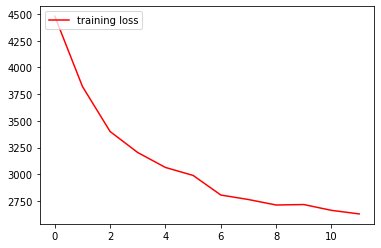

In [6]:
#training
import time
import matplotlib.pyplot as plt
import numpy as np

net.to(device)

start_time = time.time()

loss_history = []
epoch = 2
for e in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0

print('Finished Training')

print("Training time in %s seconds ---" % (time.time() - start_time))

plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = "upper left")
plt.show()

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

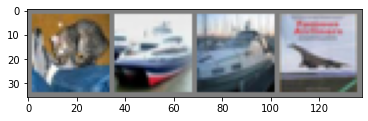

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%5s" % classes[labels[j]] for j in range(4)))


In [9]:
#load the trained network
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
#testing
net.to(device)

start_time = time.time()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted_labels = torch.max(outputs.data, 1)
        total += groundtruth_labels.size(0)
        correct += (predicted_labels == groundtruth_labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

print("Testing time is in %s seconds ---" % (time.time() - start_time))

Accuracy of the network on the 10000 test images: 55 %
Testing time is in 14.587864875793457 seconds ---


In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels=data
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
        c=(predicted_labels == groundtruth_labels).squeeze()
        for i in range(4):
            label = groundtruth_labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1

for i in range(10):
    print("Accuracy of %5s:%2d %%"%(classes[i], 100*class_correct[i]/class_total[i]))
    

Accuracy of plane:57 %
Accuracy of   car:67 %
Accuracy of  bird:37 %
Accuracy of   cat:42 %
Accuracy of  deer:48 %
Accuracy of   dog:46 %
Accuracy of  frog:53 %
Accuracy of horse:70 %
Accuracy of  ship:78 %
Accuracy of truck:47 %


Compute the confusion matrix

In [12]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=len(testset))


net.to(device)
start_time = time.time()
correct, total = 0, 0
with torch.no_grad():
    for data in test_loader:
        images, groundtruth_labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted_labels = torch.max(outputs.data, 1)
        total += groundtruth_labels.size(0)
        correct += (predicted_labels == groundtruth_labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("Testing time is in %s seconds ---" % (time.time() - start_time))


import sklearn
from sklearn.metrics import confusion_matrix
print("ground truth labels: ", groundtruth_labels)
print("predicted labels: ", predicted_labels)
conf_matr= confusion_matrix(groundtruth_labels, predicted_labels)
print("consusion matrix: ", conf_matr)

Accuracy of the network on the 10000 test images: 55 %
Testing time is in 5.363095760345459 seconds ---
ground truth labels:  tensor([3, 8, 8,  ..., 5, 1, 7])
predicted labels:  tensor([3, 8, 0,  ..., 5, 1, 7])
consusion matrix:  [[578  19  78  40  21   5  12  40 184  23]
 [ 51 676   7  27   8   7  10  40 104  70]
 [ 67  10 372 113 146  79  54 115  34  10]
 [ 15  16  66 427  92 194  63  91  27   9]
 [ 27   7  83  78 489  37  59 199  18   3]
 [ 11   5  64 224  68 467  34 114  12   1]
 [  5  14  51 141 135  32 531  67  19   5]
 [ 14   4  21  78  71  75  10 709   8  10]
 [ 93  33  13  24   5  10   3  25 782  12]
 [ 45 175  20  47   3   9  10 102 117 472]]


# Build deeper CNN

[1,    90] loss: 199.500
[2,    90] loss: 176.350
[3,    90] loss: 141.962
[4,    90] loss: 102.995
[5,    90] loss: 80.852
[6,    90] loss: 74.487
[7,    90] loss: 54.191
[8,    90] loss: 75.983
[9,    90] loss: 46.703
[10,    90] loss: 44.860
Finished Training
Training time in 39.560381174087524 seconds ---


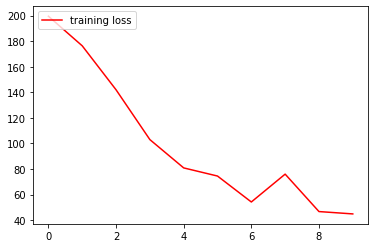

In [13]:
from torchvision import datasets
import torchvision.transforms as transforms
import torch
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = datasets.ImageFolder("FoodImages/Train", transform=transform)
testset = datasets.ImageFolder("FoodImages/Test", transform=transform)
classes = ("Cakes", "Pasta", "Pizza")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=1, 
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=len(testset), 
                                         shuffle=False, num_workers=2)

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import torch.nn as nn
import torch.nn.functional as F
import time
from torchvision import datasets
import torch.optim as optim
import sklearn
from sklearn.metrics import confusion_matrix

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 10, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(10, 15, 3)
        self.conv4 = nn.Conv2d(15, 20, 3)

        self.fc1 = nn.Linear(80, 3)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        print(x.size())
        x = F.relu(self.conv1(x))
        print(x.size())
        x = self.pool(x)
        print(x.size())
        x = F.relu(self.conv2(x))
        print(x.size())
        x = self.pool(x)
        print(x.size())
        x = F.relu(self.conv3(x))
        print(x.size())
        # x = self.pool(x)
        x = F.relu(self.conv4(x))
        print(x.size())
        x = x.view(-1, 80)
        print(x.size())
        x = self.fc1(x)
        print(x.size())

        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mynet = Net()#MyNet() # mynet for optimized architecture

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(mynet.parameters(), lr=0.001, momentum=0.9)

mynet.to(device)
start_time = time.time()
loss_history = []
epoch = 10#30  # 30 for optimized parameter
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,80], gamma=0.1)

for e in range(epoch):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = mynet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
    print('[%d, %5d] loss: %.3f' %(e + 1, i + 1, running_loss))
    scheduler.step()
    loss_history.append(running_loss)

print('Finished Training')

print("Training time in %s seconds ---" % (time.time() - start_time))

plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = "upper left")
plt.show()
PATH = './food_net.pth'
torch.save(net.state_dict(), PATH)